# Preprocesamiento del datasets COVID

In [1]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import os
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import zipfile
import io
from openpyxl import load_workbook, Workbook

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

## Inspección de los datos

### Cargar datos

In [3]:
# Path al archivo
file_path ='../../data/raw/COVID19MEXICO.parquet'
# Cargar archivo CSV como DataFrame
df = pd.read_parquet(file_path)
# Inspeccionar primeros elementos del DataFrame
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2024-04-23,c9a5ed,2,12,9,2,9,9,9,1,...,2,2,97,1,2,7,99,México,97,97
1,2024-04-23,cbecc9,2,6,5,1,5,5,28,1,...,2,2,97,1,2,7,99,México,97,97
2,2024-04-23,1b6d59,1,12,9,1,9,9,12,1,...,1,2,97,1,1,3,99,México,97,97
3,2024-04-23,0ed066,2,12,16,2,16,16,41,1,...,2,2,97,1,2,7,99,México,97,97
4,2024-04-23,7aeb5d,2,12,3,1,15,3,3,1,...,1,2,97,1,2,7,99,México,97,97


### Dimensiones de los datos

In [4]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df.shape}\n")

Dimensión de los datos: (1296717, 40)



### Columnas

In [5]:
# Inspeccionar el nombre de las columnas
df.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

### Valores faltantes

In [6]:
print(f"Valores faltantes por columna:\n\n {df.isna().sum()}")
print(f"\nValores faltantes totales: {df.isna().sum().sum()}")

Valores faltantes por columna:

 FECHA_ACTUALIZACION      0
ID_REGISTRO              0
ORIGEN                   0
SECTOR                   0
ENTIDAD_UM               0
SEXO                     0
ENTIDAD_NAC              0
ENTIDAD_RES              0
MUNICIPIO_RES            0
TIPO_PACIENTE            0
FECHA_INGRESO            0
FECHA_SINTOMAS           0
FECHA_DEF                0
INTUBADO                 0
NEUMONIA                 0
EDAD                     0
NACIONALIDAD             0
EMBARAZO                 0
HABLA_LENGUA_INDIG       0
INDIGENA                 0
DIABETES                 0
EPOC                     0
ASMA                     0
INMUSUPR                 0
HIPERTENSION             0
OTRA_COM                 0
CARDIOVASCULAR           0
OBESIDAD                 0
RENAL_CRONICA            0
TABAQUISMO               0
OTRO_CASO                0
TOMA_MUESTRA_LAB         0
RESULTADO_LAB            0
TOMA_MUESTRA_ANTIGENO    0
RESULTADO_ANTIGENO       0
CLASIFICACION_FINAL   

### Tipos de datos

In [7]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df.dtypes}\n")

Tipo de dato de cada variable:
 FECHA_ACTUALIZACION      object
ID_REGISTRO              object
ORIGEN                    int64
SECTOR                    int64
ENTIDAD_UM                int64
SEXO                      int64
ENTIDAD_NAC               int64
ENTIDAD_RES               int64
MUNICIPIO_RES             int64
TIPO_PACIENTE             int64
FECHA_INGRESO            object
FECHA_SINTOMAS           object
FECHA_DEF                object
INTUBADO                  int64
NEUMONIA                  int64
EDAD                      int64
NACIONALIDAD              int64
EMBARAZO                  int64
HABLA_LENGUA_INDIG        int64
INDIGENA                  int64
DIABETES                  int64
EPOC                      int64
ASMA                      int64
INMUSUPR                  int64
HIPERTENSION              int64
OTRA_COM                  int64
CARDIOVASCULAR            int64
OBESIDAD                  int64
RENAL_CRONICA             int64
TABAQUISMO                int64
OTRO_CAS

Más adelante va a ser necesario manipular las columnas con fechas (FECHA_INGRESO, FECHA_DEF y FECHA_SINTOMAS) y las variables de país (PAIS_NACIONALIDAD y PAIS_ORIGEN)

## Filtrado de nuestro Dataframe

In [8]:
# Creamos una copia de nuestro Dataframe
df_filtered = df.copy()

Para evitar confusiones, dado que existen redundancias en los valores de CLASIFICACION_FINAL, nos quedamos solamente con los valores 3 y 7 que determinan sin lugar a duda diagnósticos positivos y negativos de COVID-19, respectivamente

In [9]:
# Evaluamos la presencia de los distintos valores únicos de CLASIFICACIO_FINAL
df_filtered['CLASIFICACION_FINAL'].value_counts()

CLASIFICACION_FINAL
7    749373
3    426570
6    108081
1      7948
5      4492
4       227
2        26
Name: count, dtype: int64

In [10]:
# Filtrar por valores de variable objetivo CLASIFICACION_FINAL
df_filtered = df_filtered[df_filtered['CLASIFICACION_FINAL'].isin([3,7])]

# Mapear los valores 3 a 1 y 7 a 0 para manejar un código binario
df_filtered['CLASIFICACION_FINAL'].replace({3: 1, 7: 0}, inplace=True)

# Hacemos un Reset te los índices
df_filtered.reset_index(drop=True, inplace=True)

## Transformación de columnas

In [11]:
# Creamos una copia de nuestro Dataframe sin la variable objetivo
df_transformed = df_filtered.copy()

### Variable objetivo

Obtenemos nuestra variable objetivo a partir de la variable FECHA_DEF. Dado que el valor 9999-99-99 se utiliza para indicar que la persona no falleció, podemos crear una nueva variable binaria DEFUNCION como sigue:

In [12]:
# Extraer año, mes y día como nuevas columnas
df_transformed['DEFUNCION'] = (df_transformed['FECHA_DEF'] != '9999-99-99').astype(int)
# Mapeamos los valores 0 a 2 para que coincida con el catálogo SI_NO
df_transformed['DEFUNCION'].replace({0: 2}, inplace=True)
# Eliminar la columna original
df_transformed = df_transformed.drop(columns='FECHA_DEF', axis=1)

### Nos deshacemos de la columna ID_REGISTRO

In [13]:
df_transformed = df_transformed.drop('ID_REGISTRO', axis=1)

### Conversión de columnas con fechas

Separamos los valores de año, mes y día en columnas distintas. 

FECHA_ACTUALIZACION

In [14]:
# Inspeccionar los valores originales
df_transformed[['FECHA_ACTUALIZACION']].head()

,FECHA_ACTUALIZACION
0,2024-04-23
1,2024-04-23
2,2024-04-23
3,2024-04-23
4,2024-04-23


In [15]:
# Extraer año, mes y día como nuevas columnas
df_transformed['AÑO_ACTUALIZACION'] = pd.to_datetime(df_transformed['FECHA_ACTUALIZACION']).dt.year
df_transformed['MES_ACTUALIZACION'] = pd.to_datetime(df_transformed['FECHA_ACTUALIZACION']).dt.month
df_transformed['DIA_ACTUALIZACION'] = pd.to_datetime(df_transformed['FECHA_ACTUALIZACION']).dt.day
# Eliminar la columna original
df_transformed = df_transformed.drop(columns='FECHA_ACTUALIZACION', axis=1)

In [16]:
# Inspeccionar las nuevas columnas
df_transformed[['AÑO_ACTUALIZACION', 'MES_ACTUALIZACION', 'DIA_ACTUALIZACION']].head()

,AÑO_ACTUALIZACION,MES_ACTUALIZACION,DIA_ACTUALIZACION
0,2024,4,23
1,2024,4,23
2,2024,4,23
3,2024,4,23
4,2024,4,23


FECHA_INGRESO

In [17]:
# Inspeccionar los valores originales
df_transformed[['FECHA_INGRESO']].head()

,FECHA_INGRESO
0,2023-02-26
1,2023-03-24
2,2023-03-02
3,2023-03-09
4,2023-06-12


In [18]:
# Extraer año, mes y día como nuevas columnas
df_transformed['AÑO_INGRESO'] = pd.to_datetime(df_transformed['FECHA_INGRESO']).dt.year
df_transformed['MES_INGRESO'] = pd.to_datetime(df_transformed['FECHA_INGRESO']).dt.month
df_transformed['DIA_INGRESO'] = pd.to_datetime(df_transformed['FECHA_INGRESO']).dt.day
# Eliminar la columna original
df_transformed = df_transformed.drop(columns='FECHA_INGRESO', axis=1)

In [19]:
# Inspeccionar las nuevas columnas
df_transformed[['AÑO_INGRESO', 'MES_INGRESO', 'DIA_INGRESO']].head()

,AÑO_INGRESO,MES_INGRESO,DIA_INGRESO
0,2023,2,26
1,2023,3,24
2,2023,3,2
3,2023,3,9
4,2023,6,12


FECHA_SINTOMAS

In [20]:
# Inspeccionar los valores originales
df_transformed[['FECHA_SINTOMAS']].head()

,FECHA_SINTOMAS
0,2023-02-22
1,2023-03-19
2,2023-03-01
3,2023-03-06
4,2023-06-09


In [21]:
# Extraer año, mes y día como nuevas columnas
df_transformed['AÑO_SINTOMAS'] = pd.to_datetime(df_transformed['FECHA_SINTOMAS']).dt.year
df_transformed['MES_SINTOMAS'] = pd.to_datetime(df_transformed['FECHA_SINTOMAS']).dt.month
df_transformed['DIA_SINTOMAS'] = pd.to_datetime(df_transformed['FECHA_SINTOMAS']).dt.day
# Eliminar la columna original
df_transformed = df_transformed.drop(columns='FECHA_SINTOMAS', axis=1)

In [22]:
# Inspeccionar las nuevas columnas
df_transformed[['AÑO_SINTOMAS', 'MES_SINTOMAS', 'DIA_SINTOMAS']].head()

,AÑO_SINTOMAS,MES_SINTOMAS,DIA_SINTOMAS
0,2023,2,22
1,2023,3,19
2,2023,3,1
3,2023,3,6
4,2023,6,9


### Label Encoding de columnas con países

In [23]:
print(f"PAIS_NACIONALIDAD:\n\n{np.sort(df_transformed['PAIS_NACIONALIDAD'].unique())}")

PAIS_NACIONALIDAD:

['99' 'Afganistán' 'Alemania' 'Arabia Saudita' 'Argelia' 'Argentina'
 'Australia' 'Austria' 'Bangladesh' 'Belice' 'Bielorrusia' 'Bolivia'
 'Brasil' 'Bulgaria' 'Burundi' 'Bélgica' 'Camboya' 'Canadá' 'Chile'
 'China' 'Colombia' 'Congo' 'Costa de Marfil' 'Croacia' 'Cuba' 'Dinamarca'
 'Ecuador' 'Egipto' 'El Salvador' 'El Vaticano' 'España'
 'Estado Libre Asociado de Puerto Rico' 'Estados Unidos de América'
 'Estonia' 'Filipinas' 'Finlandia' 'Francia' 'Georgia'
 'Gran Bretaña (Reino Unido)' 'Guatemala' 'Guinea' 'Guinea Ecuatorial'
 'Guyana Francesa' 'Haití' 'Holanda' 'Hong Kong' 'Hungría' 'India' 'Iraq'
 'Irán' 'Italia' 'Jamaica' 'Japón' 'Lituania' 'Líbano' 'Macao'
 'Mauritania' 'Micronesia' 'Moldavia' 'Mozambique' 'México' 'Nicaragua'
 'Nigeria' 'Noruega' 'Níger' 'Otro' 'Pakistán' 'Paraguay'
 'Países de la Ex-Yugoslavia' 'Perú' 'Polonia' 'Portugal'
 'Reino Hachemita de Jordania' 'Reino de Swazilandia'
 'República Centro Africana' 'República Checa y República Eslovaca'
 

In [24]:
print(f"PAIS_ORIGEN:\n\n{np.sort(df_transformed['PAIS_ORIGEN'].unique())}")

PAIS_ORIGEN:

['97' 'Afganistán' 'Alemania' 'Argentina' 'Australia' 'Austria' 'Belice'
 'Bolivia' 'Brasil' 'Canadá' 'Chile' 'China' 'Colombia' 'Cuba' 'Ecuador'
 'El Salvador' 'España' 'Estado Libre Asociado de Puerto Rico'
 'Estados Unidos de América' 'Georgia' 'Gran Bretaña (Reino Unido)'
 'Guatemala' 'Guinea' 'Guinea Ecuatorial' 'Guyana Francesa' 'Haití'
 'Holanda' 'Hungría' 'India' 'Italia' 'Japón' 'Mauritania' 'Nicaragua'
 'Nigeria' 'Níger' 'Otro' 'Perú' 'Portugal' 'Reino Hachemita de Jordania'
 'República Centro Africana' 'República Dominicana'
 'República Oriental del Uruguay' 'República de Angola'
 'República de Corea' 'República de Costa Rica' 'República de Honduras'
 'República de Panamá' 'Rusia' 'Senegal' 'Siria' 'Surinam' 'Venezuela']


Juntamos los valores únicos de ambas columnas y después aplicamos el Label Encoding de modo que un mismo valor reciba el mismo código en ambas columnas.

In [25]:
from sklearn.preprocessing import LabelEncoder

# Unificar los valores únicos de ambas columnas
valores_unicos = set(df_transformed['PAIS_NACIONALIDAD'].unique()).union(set(df_transformed['PAIS_ORIGEN'].unique()))

# Crear un único LabelEncoder
label_encoder = LabelEncoder()

# Ajustar el LabelEncoder a los valores únicos unificados
label_encoder.fit(list(valores_unicos))

# Aplicar el LabelEncoder a la columna 'PAIS_NACIONALIDAD'
df_transformed['PAIS_NACIONALIDAD'] = label_encoder.transform(df_transformed['PAIS_NACIONALIDAD'])

# Aplicar el LabelEncoder a la columna 'PAIS_ORIGEN'
df_transformed['PAIS_ORIGEN'] = label_encoder.transform(df_transformed['PAIS_ORIGEN'])

# Muestra los mapeos entre las categorías y los números asignados
print("Mapeo de etiquetas a números:\n")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Mapeo de etiquetas a números:

97: 0
99: 1
Afganistán: 2
Alemania: 3
Arabia Saudita: 4
Argelia: 5
Argentina: 6
Australia: 7
Austria: 8
Bangladesh: 9
Belice: 10
Bielorrusia: 11
Bolivia: 12
Brasil: 13
Bulgaria: 14
Burundi: 15
Bélgica: 16
Camboya: 17
Canadá: 18
Chile: 19
China: 20
Colombia: 21
Congo: 22
Costa de Marfil: 23
Croacia: 24
Cuba: 25
Dinamarca: 26
Ecuador: 27
Egipto: 28
El Salvador: 29
El Vaticano: 30
España: 31
Estado Libre Asociado de Puerto Rico: 32
Estados Unidos de América: 33
Estonia: 34
Filipinas: 35
Finlandia: 36
Francia: 37
Georgia: 38
Gran Bretaña (Reino Unido): 39
Guatemala: 40
Guinea: 41
Guinea Ecuatorial: 42
Guyana Francesa: 43
Haití: 44
Holanda: 45
Hong Kong: 46
Hungría: 47
India: 48
Iraq: 49
Irán: 50
Italia: 51
Jamaica: 52
Japón: 53
Lituania: 54
Líbano: 55
Macao: 56
Mauritania: 57
Micronesia: 58
Moldavia: 59
Mozambique: 60
México: 61
Nicaragua: 62
Nigeria: 63
Noruega: 64
Níger: 65
Otro: 66
Pakistán: 67
Paraguay: 68
Países de la Ex-Yugoslavia: 69
Perú: 70
Polonia: 

In [26]:
# Restamos 1 a los nuevos valores para que la codificación coincida con el mapeo {99:0, 98:-1, 97:-2}
df_transformed['PAIS_NACIONALIDAD'] = df_transformed['PAIS_NACIONALIDAD'] - 1
df_transformed['PAIS_ORIGEN'] = df_transformed['PAIS_ORIGEN'] - 1

# Volvemos a restar 1 solo a los valores -1 para que la codificación coincida con el mapeo {99:0, 98:-1, 97:-2}
df_transformed.loc[df_transformed['PAIS_NACIONALIDAD'] == -1, 'PAIS_NACIONALIDAD'] -= 1
df_transformed.loc[df_transformed['PAIS_ORIGEN'] == -1, 'PAIS_ORIGEN'] -= 1

Inspeccionamos los valores codificados

In [27]:
print(f"PAIS_NACIONALIDAD:\n\n{np.sort(df_transformed['PAIS_NACIONALIDAD'].unique())}")

PAIS_NACIONALIDAD:

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


In [28]:
print(f"PAIS_ORIGEN:\n\n{np.sort(df_transformed['PAIS_ORIGEN'].unique())}")

PAIS_ORIGEN:

[-2  1  2  5  6  7  9 11 12 17 18 19 20 24 26 28 30 31 32 37 38 39 40 41
 42 43 44 46 47 50 52 56 61 62 64 65 69 71 72 74 77 78 79 80 81 82 83 86
 88 90 94 98]


#### Creamos el Catálogo de estos valores

In [29]:
from openpyxl import load_workbook

# Crear el diccionario mapeo_etiquetas_a_numeros utilizando la iteración
mapeo_etiquetas_a_numeros = {label: (i - 1) for i, label in enumerate(label_encoder.classes_) }

# Crear un DataFrame a partir del diccionario
df_paises = pd.DataFrame(list(mapeo_etiquetas_a_numeros.items()), columns=['PAIS', 'CLAVE_PAIS'])

# Reordenar columnas
df_paises = df_paises[['CLAVE_PAIS', 'PAIS']]

# Ruta del archivo Excel
file_path = "../../references/processed/Catalogos_local_v2.xlsx"

# Verificar si el archivo existe y es un archivo Excel válido
try:
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
        df_paises.to_excel(writer, sheet_name='Catálogo PAISES', index=False)
except Exception as e:
    print(f"Error: {e}")

Error: Sheet 'Catálogo PAISES' already exists and if_sheet_exists is set to 'error'.


### Label Encoding de columna MUNICIPIO_RES

In [30]:
# Inspeccionar los valores originales
print(f"MUNICIPIO_RES:\n\n{np.sort(df_transformed['MUNICIPIO_RES'].unique())}")

MUNICIPIO_RES:

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 219 220 221 222 224 225 226 227 229 230 232 233 234 235 236 238 239
 240 242 243 244 245 246 247 248 24

Dado que las distintas entidades ya están codificadas numéricamente, solamente codificamos los valores "999" para que evitar que el modelo le adjudique un mayor peso que al resto de valores.

In [31]:
# Mapear los valores 99 a 0
df_transformed['MUNICIPIO_RES'].replace({999: 0}, inplace=True)

In [32]:
# Inspeccionar los valores codificados
print(f"MUNICIPIO_RES:\n\n{np.sort(df_transformed['MUNICIPIO_RES'].unique())}")


MUNICIPIO_RES:

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 219 220 221 222 224 225 226 227 229 230 232 233 234 235 236 238
 239 240 242 243 244 245 246 247 24

### Label Encoding de columnas valores 97, 98 o 99

Identificamos las columnas con valores 97, 98 o 99. Ignorando las columnas 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'MUNICIPIO_RES' y 'EDAD', porque en estas los estos valores sí son válidos. 

In [33]:
# Lista para almacenar columnas con valores 97, 98, 99
columnas_con_valores = []

# Iteramos a lo largo de las columnas y evaluamos la condición 
for columna in df_transformed.drop(['PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'MUNICIPIO_RES', 'EDAD'], axis=1).columns:
    if df_transformed[columna].isin([97, 98, 99]).any():
        columnas_con_valores.append(columna)

# Inspeccionar las columnas con valores 97, 98 y 99
print(columnas_con_valores)

['SECTOR', 'ENTIDAD_NAC', 'INTUBADO', 'NEUMONIA', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'RESULTADO_LAB', 'RESULTADO_ANTIGENO', 'MIGRANTE', 'UCI']


Mapeamos los valores 97 a -2, 98 a -1 y 99 a 0

In [34]:
# Mapear los valores 99 a 0, 98 a -1 y 97 a -2
for columna in columnas_con_valores:
    df_transformed[columna].replace({99:0, 98:-1, 97:-2}, inplace=True)
    print(f"{columna}: {np.sort(df_transformed[columna].unique())}\n")

SECTOR: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

ENTIDAD_NAC: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]

INTUBADO: [-2  0  1  2]

NEUMONIA: [0 1 2]

EMBARAZO: [-2 -1  0  1  2]

HABLA_LENGUA_INDIG: [0 1 2]

INDIGENA: [0 1 2]

DIABETES: [-1  1  2]

EPOC: [-1  1  2]

ASMA: [-1  1  2]

INMUSUPR: [-1  1  2]

HIPERTENSION: [-1  1  2]

OTRA_COM: [-1  1  2]

CARDIOVASCULAR: [-1  1  2]

OBESIDAD: [-1  1  2]

RENAL_CRONICA: [-1  1  2]

TABAQUISMO: [-1  1  2]

OTRO_CASO: [0 1 2]

RESULTADO_LAB: [-2  1  2  4]

RESULTADO_ANTIGENO: [-2  1  2]

MIGRANTE: [0 1 2]

UCI: [-2  0  1  2]



### Inspeccionar el nuevo Dataframe

In [35]:
df_transformed

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,DEFUNCION,AÑO_ACTUALIZACION,MES_ACTUALIZACION,DIA_ACTUALIZACION,AÑO_INGRESO,MES_INGRESO,DIA_INGRESO,AÑO_SINTOMAS,MES_SINTOMAS,DIA_SINTOMAS
0,2,12,9,2,9,9,9,1,-2,2,...,2,2024,4,23,2023,2,26,2023,2,22
1,2,6,5,1,5,5,28,1,-2,2,...,2,2024,4,23,2023,3,24,2023,3,19
2,1,12,9,1,9,9,12,1,-2,2,...,2,2024,4,23,2023,3,2,2023,3,1
3,2,12,16,2,16,16,41,1,-2,2,...,2,2024,4,23,2023,3,9,2023,3,6
4,2,12,3,1,15,3,3,1,-2,2,...,2,2024,4,23,2023,6,12,2023,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175938,2,12,15,2,30,15,33,1,-2,0,...,2,2024,4,23,2023,8,30,2023,8,30
1175939,2,3,15,1,20,15,0,1,-2,0,...,2,2024,4,23,2023,8,30,2023,8,30
1175940,2,12,15,1,9,15,0,1,-2,0,...,2,2024,4,23,2023,8,30,2023,8,30
1175941,2,3,15,2,15,15,0,1,-2,0,...,2,2024,4,23,2023,8,31,2023,8,31


In [36]:
# Inspeccionar las columnas originales
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_transformed.dtypes)

ORIGEN                   int64
SECTOR                   int64
ENTIDAD_UM               int64
SEXO                     int64
ENTIDAD_NAC              int64
ENTIDAD_RES              int64
MUNICIPIO_RES            int64
TIPO_PACIENTE            int64
INTUBADO                 int64
NEUMONIA                 int64
EDAD                     int64
NACIONALIDAD             int64
EMBARAZO                 int64
HABLA_LENGUA_INDIG       int64
INDIGENA                 int64
DIABETES                 int64
EPOC                     int64
ASMA                     int64
INMUSUPR                 int64
HIPERTENSION             int64
OTRA_COM                 int64
CARDIOVASCULAR           int64
OBESIDAD                 int64
RENAL_CRONICA            int64
TABAQUISMO               int64
OTRO_CASO                int64
TOMA_MUESTRA_LAB         int64
RESULTADO_LAB            int64
TOMA_MUESTRA_ANTIGENO    int64
RESULTADO_ANTIGENO       int64
CLASIFICACION_FINAL      int64
MIGRANTE                 int64
PAIS_NAC

## Almacenamiento de los datos procesados

In [37]:
# Ruta de la carpeta donde se guardaran los datos procesadoos
folder_path = '../../data/processed/'

# Verificar si la carpeta no existe y crearla si es necesario
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Ahora puedes guardar el DataFrame en formato Parquet
df_transformed.to_parquet(folder_path + 'COVID19MEXICO_Processed.parquet', index=False)

### Balance de las clases

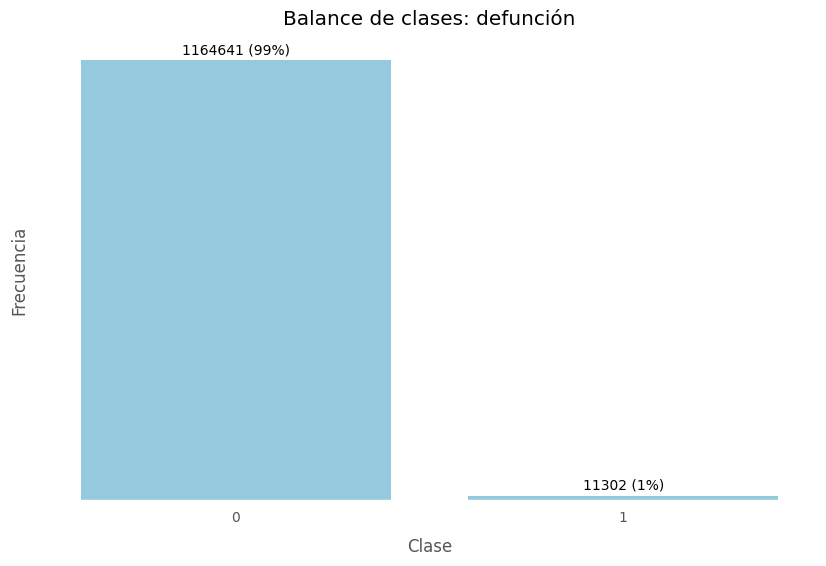

In [72]:
# Customized style
custom_style = {
    'axes.edgecolor': 'white',  # Axis layout color
    'axes.facecolor': 'white',  # Axias face color
    'grid.color': 'white',   # Grid lines color
}

plt.style.use('ggplot')  # Use ggplot as base
plt.rcParams.update(custom_style)  # Apply syle

# Gráfica de barras con seaborn
plt.figure(figsize=(10, 6)) # Tamaño de la figura
ax = sns.countplot(data=df_transformed, x='DEFUNCION', color='skyblue') # Gráfica de barras
plt.title('Balance de clases: defunción', pad=10) # Título del gráfico
plt.xlabel('Clase', labelpad=10) # Etiqueta del eje x
plt.ylabel('Frecuencia', labelpad=10) # Etiqueta del eje y

# Desactivar las marcas en el eje x
plt.tick_params(axis='x', which='both', bottom=False, top=False)

# Eliminar los valores del eje y
ax.set_yticks([])

# Anotar los valores de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())} ({round(p.get_height()/len(df_transformed) *100)}%)', (p.get_x() + p.get_width() / 2., p.get_height() + 10000), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show() # Mostrar gráfico


Se debe de tomar en cuenta el desbalance de los datos a la hora de seleccionar el modelo y el algoritmo de aprendizaje. 

### Random Forest

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_converted.drop('CLASIFICACION_FINAL', axis=1)  # Características
y = df_converted['CLASIFICACION_FINAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_classifier.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))

Matriz de confusión:
[[149410      0]
 [     0  85779]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149410
           1       1.00      1.00      1.00     85779

    accuracy                           1.00    235189
   macro avg       1.00      1.00      1.00    235189
weighted avg       1.00      1.00      1.00    235189


Precisión del modelo: 1.0


In [31]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X = df_converted.drop('CLASIFICACION_FINAL', axis=1)  # Características
y = df_converted['CLASIFICACION_FINAL']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el clasificador de Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Definir la cuadrícula de hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en cada hoja del árbol
}

# Inicializar la búsqueda de hiperparámetros utilizando validación cruzada de 5 pliegues
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo utilizando la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
best_rf_classifier = grid_search.best_estimator_

# Predecir en el conjunto de prueba con el mejor modelo
y_pred = best_rf_classifier.predict(X_test)

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nPrecisión del modelo:", accuracy_score(y_test, y_pred))
